In [1]:
import wfdb
import neurokit2 as nk
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

%matplotlib inline
plt.style.use('seaborn-v0_8')

# Set up the directory containing the MIT-BIH Arrhythmia Database files
base_path = '/Users/chkv/Downloads/mit-bih-arrhythmia-database-1.0.0/'

# Define the abnormal symbols from the updated list
abnormal_symbols = {'L', 'R', 'A', 'V', 'F', '[', '!', ']', 'e', 'E', '/'}


In [2]:
normal_patients = set()
abnormal_patients = set()
hrv_features_list = []
labels = []
patient_annotations = {}

thresholds = [0.16]

for threshold in thresholds:
    print(f"\nTesting threshold: {threshold}")
    for file in os.listdir(base_path):
        if file.endswith('.dat'):
            record_name = file[:-4]
            record_path = base_path + record_name
            record = wfdb.rdrecord(record_path)
            annotation = wfdb.rdann(record_path, 'atr')

            ecg_signal = record.p_signal[:, 0]

            methods = ["hamilton2002"]
            r_peaks_dict = {}
            for method in methods:
                try:
                    cleaned = nk.ecg_clean(ecg_signal, sampling_rate=360, method=method)
                    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=360, method=method)['ECG_R_Peaks']
                    r_peaks_dict[method] = r_peaks
                except Exception as e:
                    print(f"Error processing method {method}: {e}")
                    r_peaks_dict[method] = []

            is_abnormal = any(symbol in abnormal_symbols for symbol in annotation.symbol)
            patient_id = record_name[:3]

            if patient_id not in patient_annotations:
                patient_annotations[patient_id] = []
            patient_annotations[patient_id].extend(annotation.symbol)

            abnormal_count = sum(1 for symbol in annotation.symbol if symbol in abnormal_symbols)
            total_beats = len(annotation.symbol)
            abnormal_ratio = abnormal_count / total_beats

            is_patient_abnormal = abnormal_ratio > threshold
            if is_patient_abnormal:
                abnormal_patients.add(patient_id)
            else:
                normal_patients.add(patient_id)

            for method, r_peaks in r_peaks_dict.items():
                if len(r_peaks) == 0:
                    continue
                try:
                    hrv_freq = nk.hrv_frequency(r_peaks, sampling_rate=360, show=False)
                    hrv_features_list.append(hrv_freq.to_dict('records')[0])
                    labels.append(1 if is_patient_abnormal else 0)
                except Exception as e:
                    print(f"Error processing HRV features for method {method}: {e}")



Testing threshold: 0.16


In [3]:
hrv_df = pd.DataFrame(hrv_features_list)
hrv_df['Label'] = labels

X = hrv_df.drop(columns=['Label'])
y = hrv_df['Label']
X.head()


,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,0.000102,0.003821,0.008892,0.011489,0.005028,0.029333,0.773957,0.303142,0.391679,-4.466357
1,0.000431,0.014272,0.001632,0.000241,0.000010,0.016585,6.770229,0.098426,0.014538,-8.330212
2,0.000030,0.001651,0.001703,0.002691,0.000341,0.006416,0.632900,0.265449,0.419417,-5.917924
3,0.000163,0.012220,0.028430,0.030672,0.006194,0.077678,0.926909,0.365996,0.394856,-3.484413
4,0.000022,0.001474,0.003054,0.004364,0.000916,0.009831,0.699799,0.310677,0.443951,-5.434286


In [4]:

X_cleaned = X.dropna()
y_cleaned = y.loc[X_cleaned.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [5]:
svm = SVC(C=10, gamma=0.01, kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)



SVC(C=10, class_weight='balanced', gamma=0.01, random_state=42)

In [6]:
y_pred = svm.predict(X_test)
y_score = svm.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[4 1]
 [1 3]]
Sensitivity: 0.75
Specificity: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



ROC AUC: 0.85


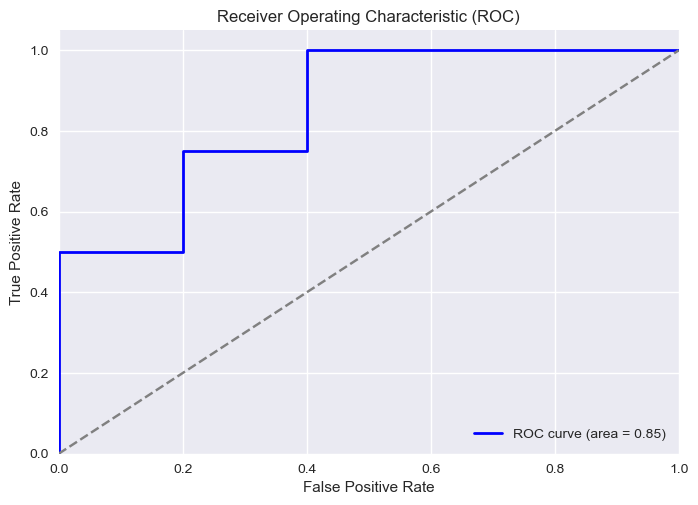

In [7]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


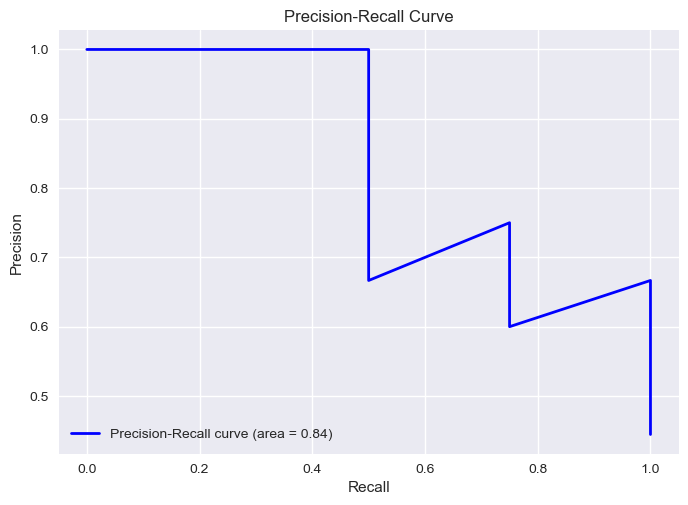

Model Evaluation Summary:
                 Metric     Score
0              Accuracy  0.777778
1  Sensitivity (Recall)  0.750000
2           Specificity  0.800000
3               ROC AUC  0.850000
4  Precision-Recall AUC  0.835417
Accuracy: 0.7777777777777778
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



In [8]:
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        (tp + tn) / (tp + tn + fp + fn),
        sensitivity,
        specificity,
        roc_auc,
        pr_auc
    ]
})

print("Model Evaluation Summary:")
print(summary)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


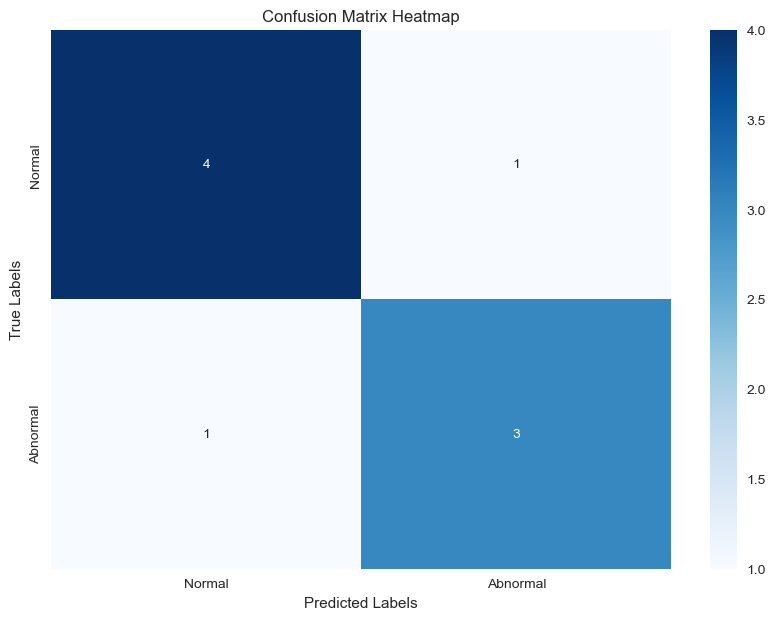

In [9]:
import seaborn as sns
import numpy as np

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define labels for the heatmap
labels = ['Normal', 'Abnormal']

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the labels, title and display the heatmap
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [10]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        (tp + tn) / (tp + tn + fp + fn),
        sensitivity,
        specificity,
        roc_auc,
        pr_auc
    ]
})

print("Model Evaluation Summary:")
display(summary)


Model Evaluation Summary:


,Metric,Score
0,Accuracy,0.777778
1,Sensitivity (Recall),0.750000
2,Specificity,0.800000
3,ROC AUC,0.850000
4,Precision-Recall AUC,0.835417
